 # <span style="color:blue">  Normalise and stack UVES spectra in 1D by summing the CCFs of the spectral orders </span>

This code will use the CCFs of UVES observations of the 51 Peg system  to recover the reflected light signal its orbiting planet

In [110]:
# Planet orbital parameters
k1 = 55.2   # m/s
k2 = 132.5  # km/s
period = 4.231
t0 = 2456021.256
PhaseZero = 0.0
mStar = 1.04 * 1.989e30  # in kg
m2sini = 0.450 * 1.898e27 / mStar  #in kg

planetTrimRV = 50.

print 'Planet orbital parameters loaded, computing RVs...'

Planet orbital parameters loaded, computing RVs...


In [111]:
# Window and order params

ccfWindowTrimRV = 10.   # in km/s

# Data Params
dataFolder = '/home/jmartins/WORK/DataReduction/51Peg_UVES_Martins_et_al_2015/CCFs/'

# possible nights:
# '2014-07-30','2014-08-17','2014-08-25','2014-09-28','2014-10-28'
dataList = ['2014-']
templateList = ['2014-']
sideList = ['redr','redl']
# bad orders
badOrders = {'redl':[0,7,8,12,13,15,22], 'redr':[0,2,8,9,11,13,15]}

ccfStarTrimRV = 20.     # in km/s

# noise cut-off limit for normalised CCFs
noiseLimitData = {'redr':8.e-3,'redl':8.e-3}
#noiseLimitTemplate =  {'redr':5.e-2,'redl':5.e-2}

print 'settings loaded'
print 'loading data...'

templateRNDLenght = 25.
templateRNDMin = 50.


settings loaded
loading data...


In [112]:
# imports
import os, sys
import numpy as np
#matplotlib
import matplotlib.pyplot as mplt
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib.cm as cm
import matplotlib.patches as patches


# 
from astropy.io import fits
from IPython.display import display, Math, Latex
import scipy.optimize as opt

# filter warnings
import warnings
warnings.filterwarnings('ignore')


print 'modules imported'


modules imported


In [113]:
# Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions
# Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions Functions

def fnRVOrbitCircular( k, PhaseZero, Phase ):
    RVStar = k * np.sin( 2. * np.pi * ( Phase + PhaseZero ) )
    return RVStar

def fnGauss(XXX, params):
    '''
    Function to model a Gaussian function with the following parameters:
        params[0] = A               params[1] = mean
        params[2] = FWHM            params[3] = B

        G(XXX) = B - A * exp(-4*ln(2)*(XXX - mean)��/ FWHM��)


    It is derived from the common gaussian function:

        G(XXX) = B + A * exp(-(XXX - mean)��/ (2*sigma��))

    by defining

        sigma = abs(FWHM)/(2*sqrt(2*ln2))

    '''
    A, mean, FWHM, B = params
    YYY = B - A * np.exp(-4 * np.log(2) * (((XXX - mean) / FWHM) ** 2))

    return YYY

def fnGaussianFitOLD( XXX, YYY, GaussParamsInitGuess = [0, 0, 1, 0] ):
    '''
    '''
    resGauss = lambda params, resXXX, resYYY: fnGauss( resXXX, params ) - resYYY

    XXX = np.array( XXX )

    GaussParams, cov,infodict,mesg,ier = opt.leastsq( resGauss, GaussParamsInitGuess, \
                                                  args = ( XXX, YYY ), maxfev = 1000000000,full_output=True )

    return GaussParams



print 'functions loaded'

functions loaded


In [114]:
# Get file lists

dataFoldersList = sorted([os.path.abspath(root) for root, subdirs, files in os.walk(dataFolder) if root != dataFolder])
dataFileList = sorted(['{}/{}'.format(folderName, fileName) for folderName in dataFoldersList for fileName in os.listdir(folderName) \
                if any(name in  fileName.lower() for name in dataList )])


templateFileList= sorted(['{}/{}'.format(folderName, fileName) for folderName in dataFoldersList for fileName in os.listdir(folderName) \
                if any(name in  fileName.lower() for name in templateList )])

print 'filelist loaded:'
print '------------------------------'
print '{:10} {} files'.format('data', len(dataFileList) )
print '{:10} {} files'.format('template', len(templateFileList))
print '------------------------------\n'
print 'loading files...'

filelist loaded:
------------------------------
data       1148 files
template   1148 files
------------------------------

loading files...


In [115]:
# load data
CCFs = {fileName: fits.open(fileName) for fileName in set(dataFileList + templateFileList)}

print 'files loaded\n'
print 'centering CCFs on star...'

files loaded

centering CCFs on star...


In [116]:
# center ccfs to star
dataCCFs = {}
for fileName in sorted(set(dataFileList + templateFileList)):
    nOrders = CCFs[fileName][0].header['NAXIS2'] 
    side = [side for side in sideList if side in fileName.lower()][0]
    
    ccfData = np.nansum([CCFs[fileName][0].data[order,:] for order in np.arange(nOrders) if order not in badOrders[side]], axis=0)
    
    rangeRVPixels = np.linspace(0,CCFs[fileName][0].header['NAXIS1']-1, num = CCFs[fileName][0].header['NAXIS1'])
    # Trimming edges of CCF and centering on star ccf guassian fit mean
    ccfAmplitude, ccfMeanPixel, ccfFWHMPixels, ccfB = fnGaussianFitOLD(rangeRVPixels,ccfData,GaussParamsInitGuess =[max(ccfData)- min(ccfData), len(ccfData)/2,10., max(ccfData)])
    trimWindowPix = CCFs[fileName][0].header['NAXIS1']/2 - ccfWindowTrimRV/CCFs[fileName][0].header['CDELT1']
    dataCCFs[fileName] = ccfData[np.floor(ccfMeanPixel-trimWindowPix):np.floor(ccfMeanPixel+trimWindowPix)]
    


ccfOrderLenght = len(dataCCFs[dataFileList[0]])
ccfHalfWidth = int((CCFs[fileName][0].header['CDELT1']*ccfOrderLenght)/2)
CCFstep = CCFs[dataFileList[0]][0].header['CDELT1']

print 'star signal centered on CCF\n'
print 'building CCF x-axis (RVs)...'

star signal centered on CCF

building CCF x-axis (RVs)...


In [117]:
# computing star window width
ccfStarTrimPix = ccfStarTrimRV/CCFs[dataFileList[0]][0].header['CDELT1']

# Building RV solution
ccfWingRVWindow = ccfHalfWidth-ccfWindowTrimRV
waveFile = np.linspace(-ccfWingRVWindow,ccfWingRVWindow,num =ccfOrderLenght )

# computing star edges
trimStarIni, trimStarEnd = int(len(waveFile)/2 -ccfStarTrimPix), int(len(waveFile)/2 + ccfStarTrimPix)

print 'x-axis has been built'
#print 'setting star signal to NaN...'

x-axis has been built


In [118]:
## Removing star
#for fileName in sorted(set(dataFileList + templateFileList)):
#    dataCCFs[fileName][trimStarIni: trimStarEnd] = np.nan

In [119]:
# computing RVs
Phases = {fileName:((CCFs[fileName][0].header['MJD-OBS'] - t0)%period)%1 for fileName in sorted(dataFileList)}
RVs = {fileName:-fnRVOrbitCircular( k2, PhaseZero, Phases[fileName] ) for fileName in sorted(dataFileList)}

RVIndexes = {fileName:np.argmin(waveFile < RVs[fileName]) for fileName in sorted(dataFileList)}

print 'RVs computed, building template...'

RVs computed, building template...


In [120]:
# Building template

template = {side: np.array(np.nansum([dataCCFs[fileName].copy() for fileName in templateFileList if side in fileName.lower()], axis = 0)) for side in sideList }

#print np.shape(template.values())
#template[][trimStarIni: trimStarEnd] = np.nan

print 'template built'
print 'normalising ccfs...'

template built
normalising ccfs...


processing side redr
processing side redl


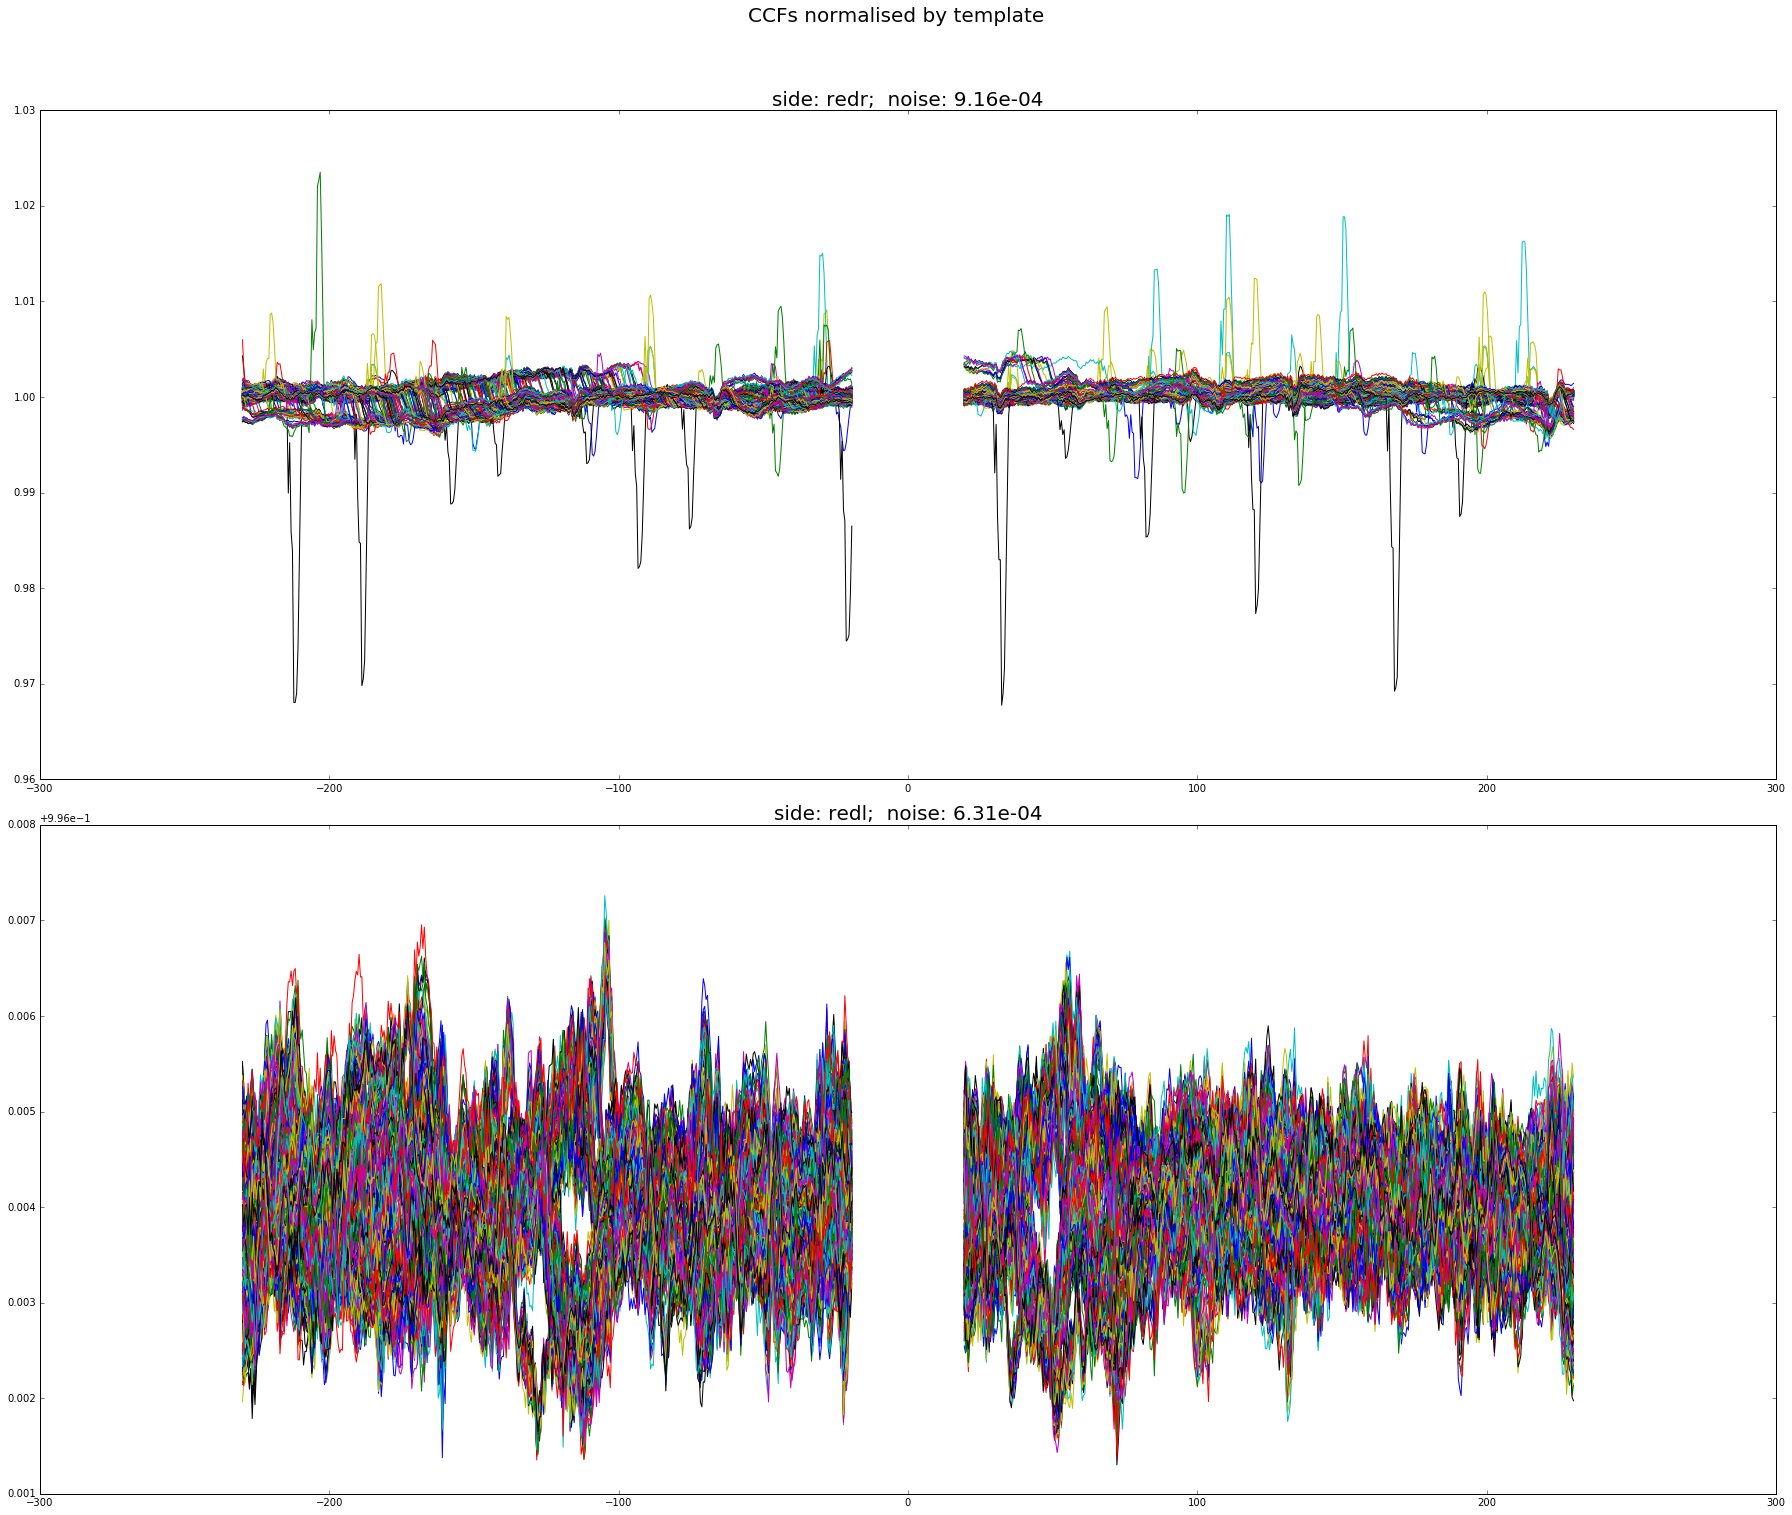

ccfs normalised
stacking CCFs...


In [121]:
# Normalise CCFs and plot them
normCCFs = {}

sideFileList = {side:[fileName for fileName in dataFileList if side in fileName.lower()] for side in sideList}

figNormCCfsOrders1D, axesNormCCfsOrders = mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

# Normalised CCFs
for side, axIndex in zip(sideList, np.arange(len(sideList))):
    print 'processing side {}'.format(side)
        
    for fileName in sorted(sideFileList[side]):
        normCCFs[fileName] = dataCCFs[fileName].copy() / template[side]
        
        
        
        amplitudeCCF= abs(np.nanmax(normCCFs[fileName]) - np.nanmin(normCCFs[fileName]))/np.nanmedian(normCCFs[fileName])
        #print amplitudeCCF
        
        if amplitudeCCF > noiseLimitData[side]:
            normCCFs[fileName][:] = 0.
            
        normCCFs[fileName][trimStarIni: trimStarEnd] = np.nan
        
        axesNormCCfsOrders[axIndex].plot(waveFile,normCCFs[fileName]/np.nanmedian(normCCFs[fileName]))
        
    noiseSTD = np.nanstd([normCCFs[fileName]/np.nanmedian(normCCFs[fileName]) for fileName in sorted(sideFileList[side])])
    axesNormCCfsOrders[axIndex].set_title('side: {};  noise: {:.2e}'.format(side, noiseSTD), fontsize = 20)
        
        
   
figNormCCfsOrders1D.suptitle('CCFs normalised by template', y=1.05, fontsize = 20)
figNormCCfsOrders1D.tight_layout()
                
#figNormCCfsOrders1D.savefig('CCFs_normalised_by_template_per_order_1D.png', format='png'   )  
mplt.show()
mplt.clf()


print 'ccfs normalised'
print 'stacking CCFs...'

574
processing side redr
0.901130128145
0.90113949713
574
processing side redl
1.0
1.0


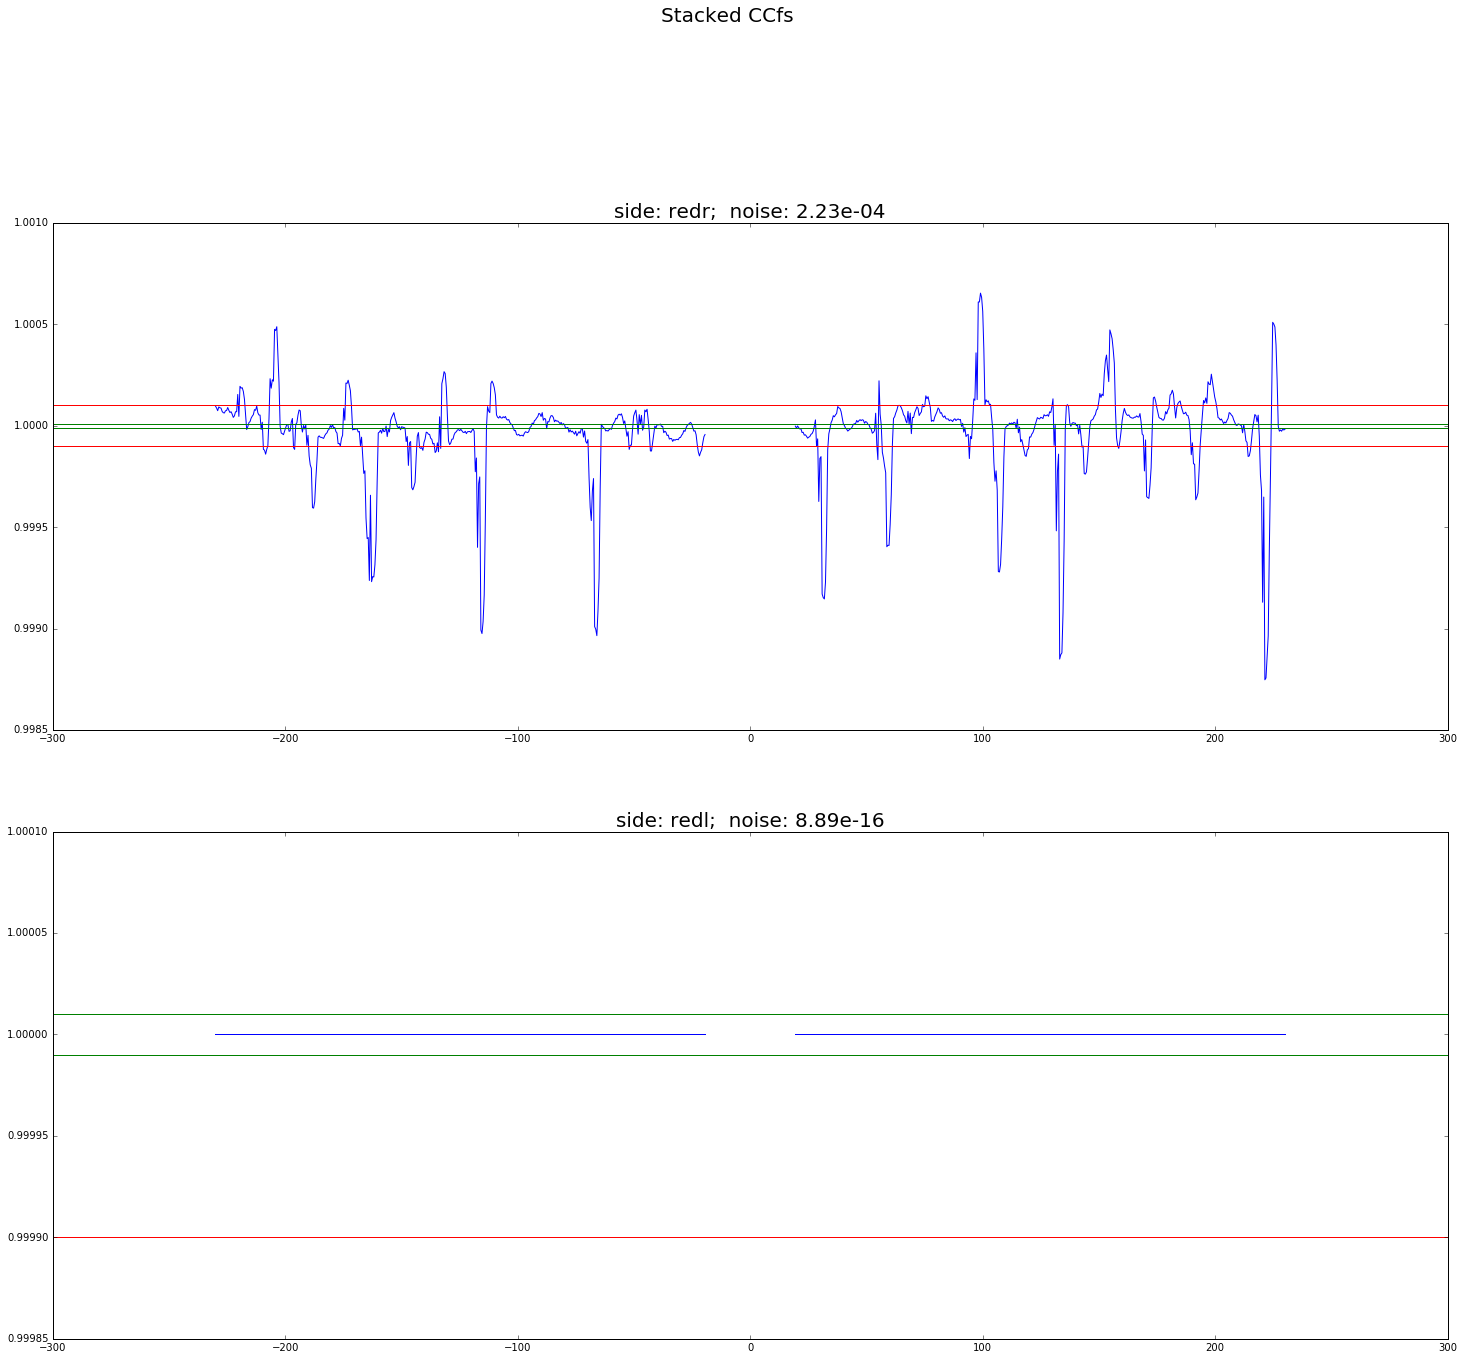

ccfs stacked
building 2D normalised CCFs per order...


In [122]:
# CCF sum

figNormCCfsStacked1D, axesNormCCfsStacked1D =  mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)



for side, axIndex in zip(sideList, np.arange(len(sideList))):
    #print normCCFs
    print len([ normCCFs[fileName].copy() for fileName in sorted(dataFileList) if side in fileName.lower()])
    stackedNormCCFs = np.nansum([ normCCFs[fileName].copy() for fileName in sorted(dataFileList) if side in fileName.lower()], axis=0)

    print 'processing side {}'.format(side)
    print np.nanmedian(stackedNormCCFs)  
    stackedNormCCFs[trimStarIni: trimStarEnd] = np.nan
    print np.nanmedian(stackedNormCCFs)
    
    
    noise1D = np.nanstd(stackedNormCCFs/np.nanmedian(stackedNormCCFs))
        
    axesNormCCfsStacked1D[axIndex].plot(waveFile,stackedNormCCFs/np.nanmedian(stackedNormCCFs))
    axesNormCCfsStacked1D[axIndex].axhline(1.-1e-4, color='red')
    axesNormCCfsStacked1D[axIndex].axhline(1.+1e-4, color='red')
    axesNormCCfsStacked1D[axIndex].axhline(1.-1e-5, color='green')
    axesNormCCfsStacked1D[axIndex].axhline(1.+1e-5, color='green')
    axesNormCCfsStacked1D[axIndex].ticklabel_format(useOffset=False)
    axesNormCCfsStacked1D[axIndex].set_title('side: {};  noise: {:.2e}'.format(side, noise1D), fontsize = 20)
    

figNormCCfsStacked1D.suptitle('Stacked CCfs'.format(side), y=1.05, fontsize = 20)    

mplt.show()
print 'ccfs stacked'
print 'building 2D normalised CCFs per order...'


stacking 2D normalised CCFs orders with noise < {'redr': 0.05, 'redl': 0.05} ...


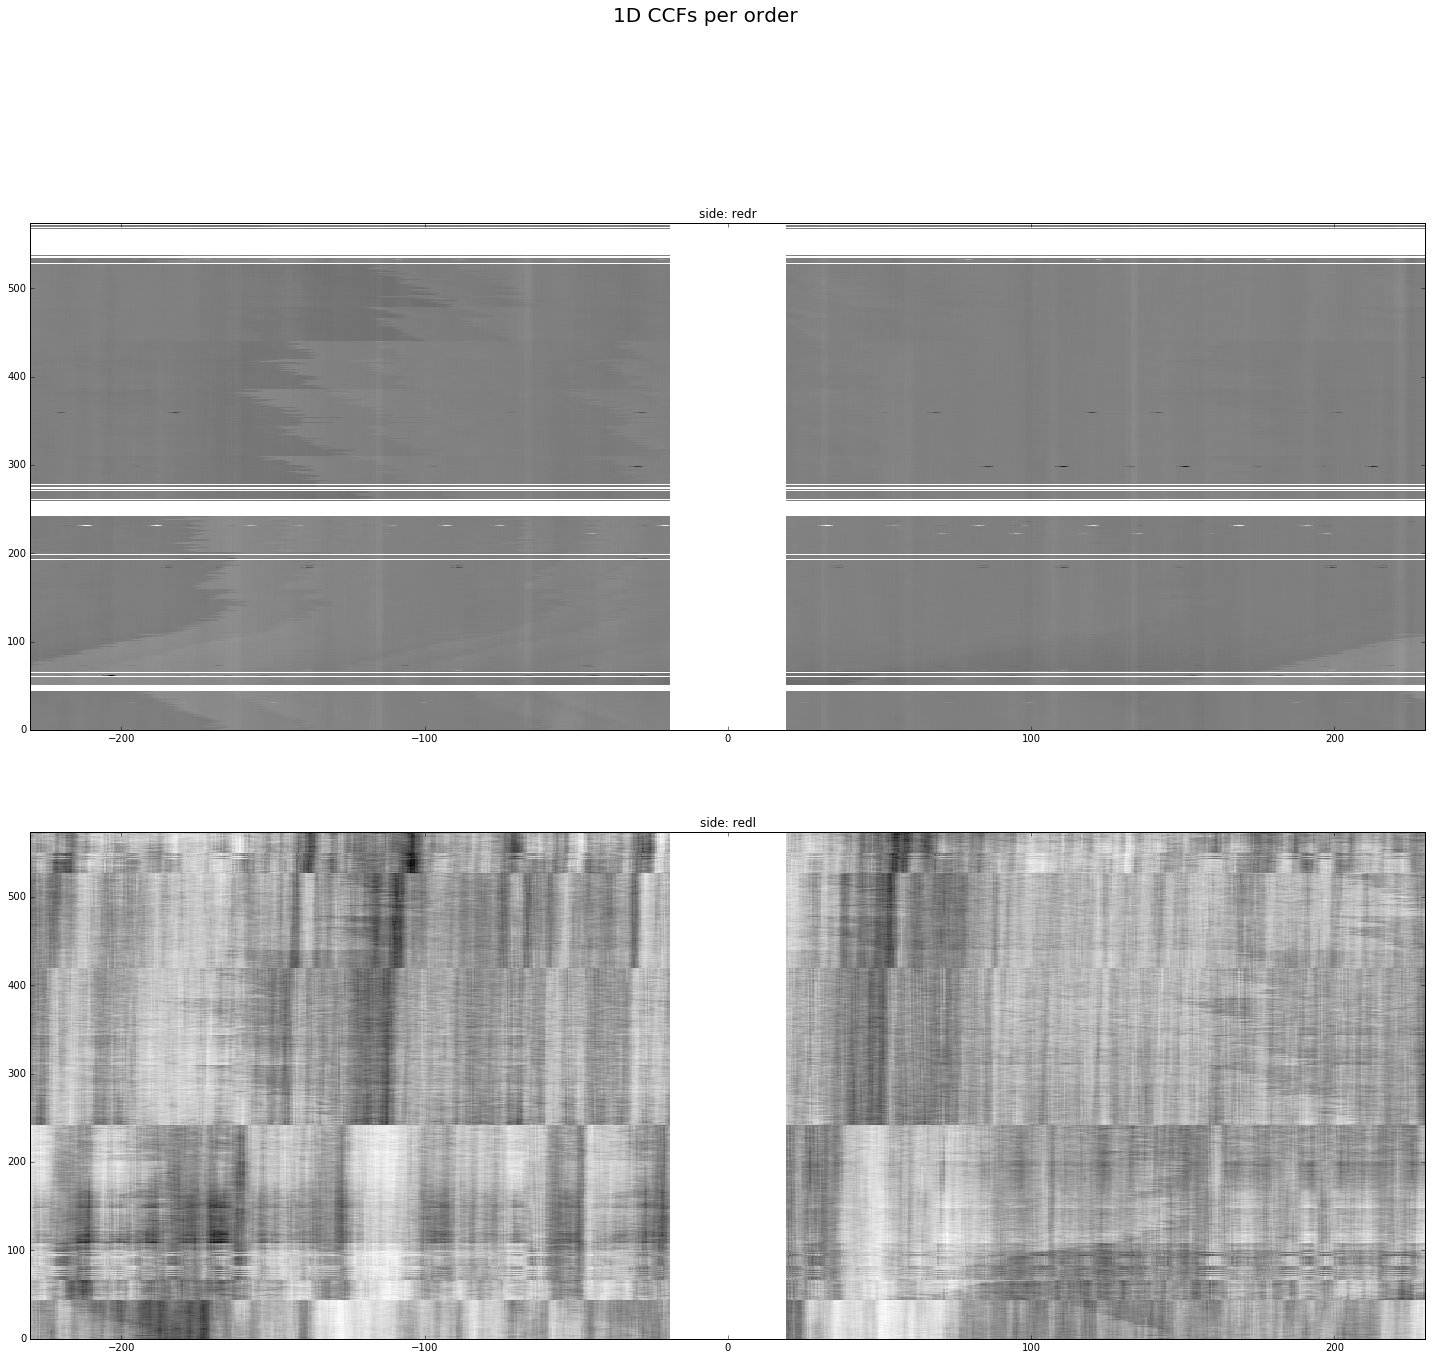

In [123]:
#2D ccfs
figNormCCfsOrders2D, axesNormCCfsOrders2D =mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

for side, axIndex in zip(sideList, np.arange(len(sideList))):
    
    axesNormCCfsOrders2D[axIndex].imshow([normCCFs[fileName]/np.nanmedian(normCCFs[fileName]) for fileName in sorted(sideFileList[side])], aspect='auto', cmap=cm.Greys,interpolation='nearest',\
           extent= [min(waveFile), max(waveFile), 0, len(sorted(sideFileList[side]))])

    axesNormCCfsOrders2D[axIndex].set_ylim([0, len(sorted(sideFileList[side]))])
    axesNormCCfsOrders2D[axIndex].set_xlim([min(waveFile), max(waveFile)])
    axesNormCCfsOrders2D[axIndex].set_title('side: {}'.format(side))

figNormCCfsOrders2D.suptitle('1D CCFs per order'.format(side), y=1.05, fontsize = 20) 

print 'stacking 2D normalised CCFs orders with noise < %s ...' %noiseLimitData

stacking 2D normalised CCFs orders with noise < {'redr': 0.05, 'redl': 0.05} ...


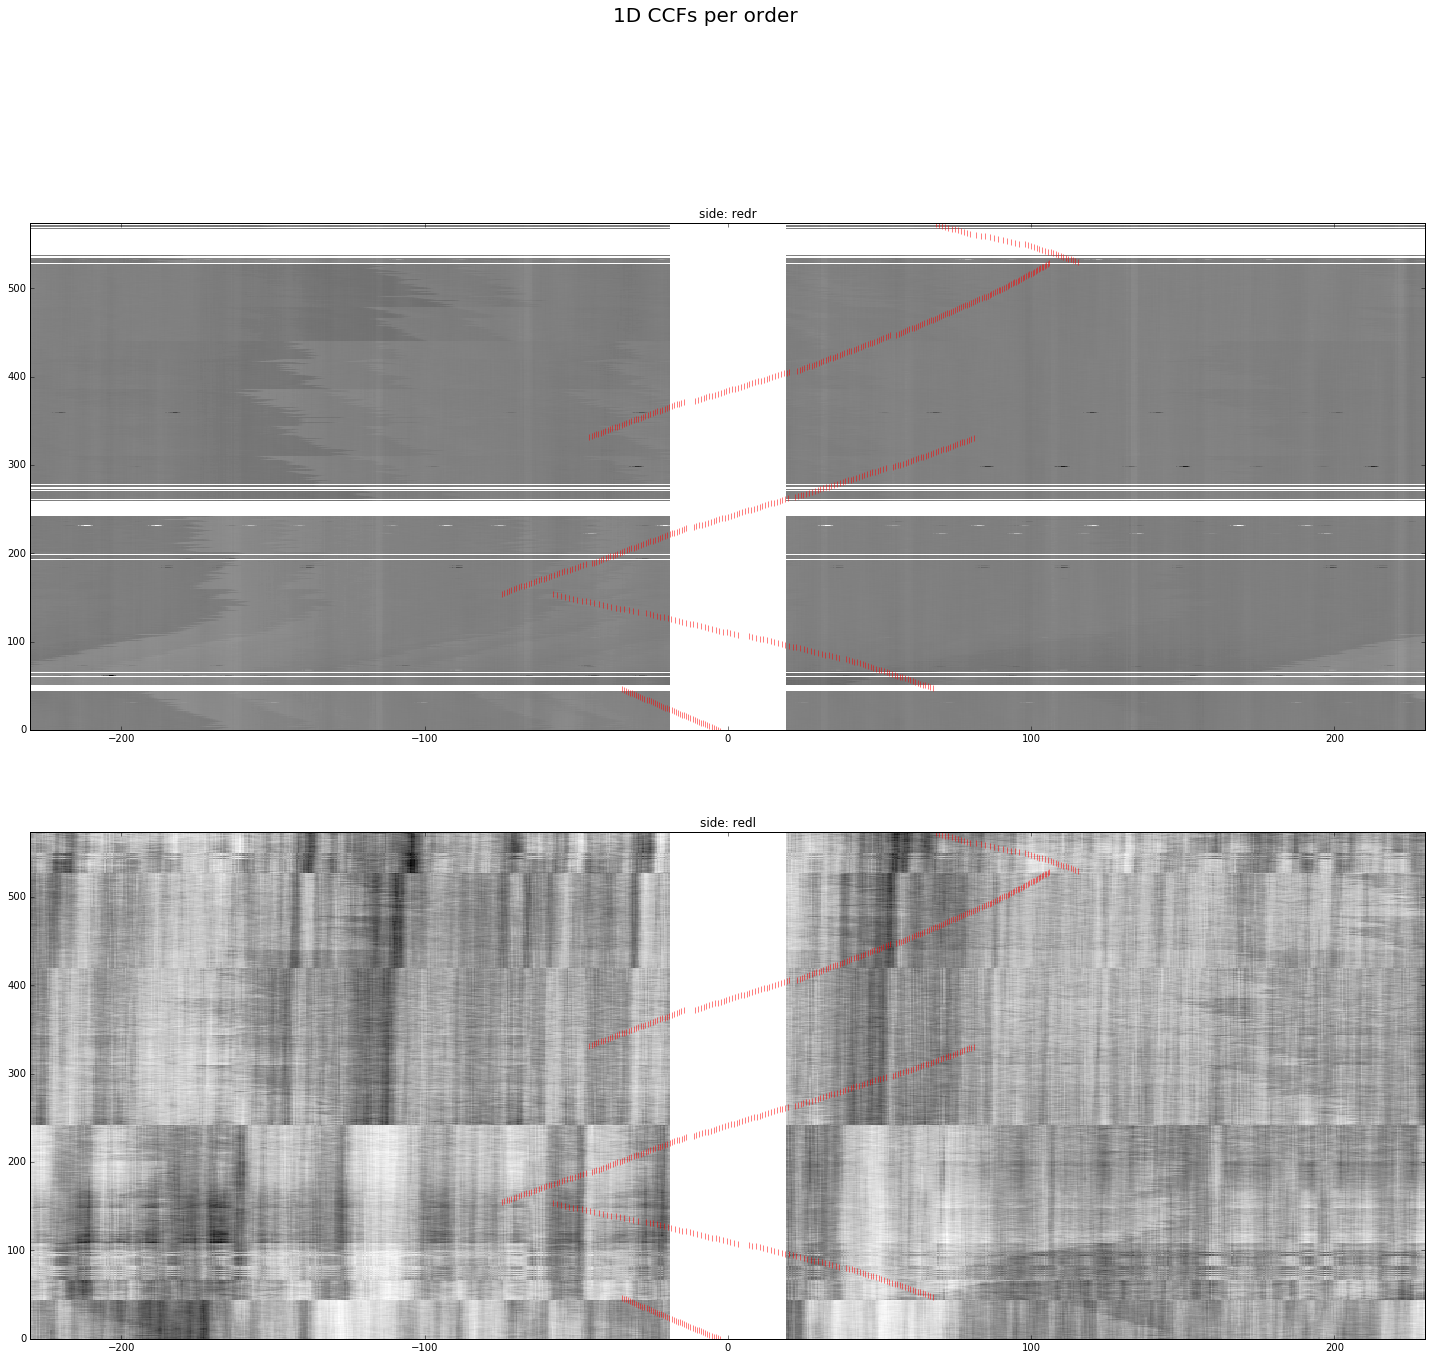

In [124]:
#2D ccfs
figNormCCfsOrders2D, axesNormCCfsOrders2D =mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

for side, axIndex in zip(sideList, np.arange(len(sideList))):
    
    axesNormCCfsOrders2D[axIndex].imshow([normCCFs[fileName]/np.nanmedian(normCCFs[fileName]) for fileName in sorted(sideFileList[side])], aspect='auto', cmap=cm.Greys,interpolation='nearest',\
           extent= [min(waveFile), max(waveFile), 0, len(sorted(sideFileList[side]))])

    axesNormCCfsOrders2D[axIndex].set_ylim([0, len(sorted(sideFileList[side]))])
    axesNormCCfsOrders2D[axIndex].set_xlim([min(waveFile), max(waveFile)])
    axesNormCCfsOrders2D[axIndex].set_title('side: {}'.format(side))
    
    axesNormCCfsOrders2D[axIndex].plot([RVs[fileName] for fileName in sorted(sideFileList[side])], [yy-.5 for yy in np.arange(len(sideFileList[side]))], 'r|')
    

figNormCCfsOrders2D.suptitle('1D CCFs per order'.format(side), y=1.05, fontsize = 20) 

print 'stacking 2D normalised CCFs orders with noise < %s ...' %noiseLimitData

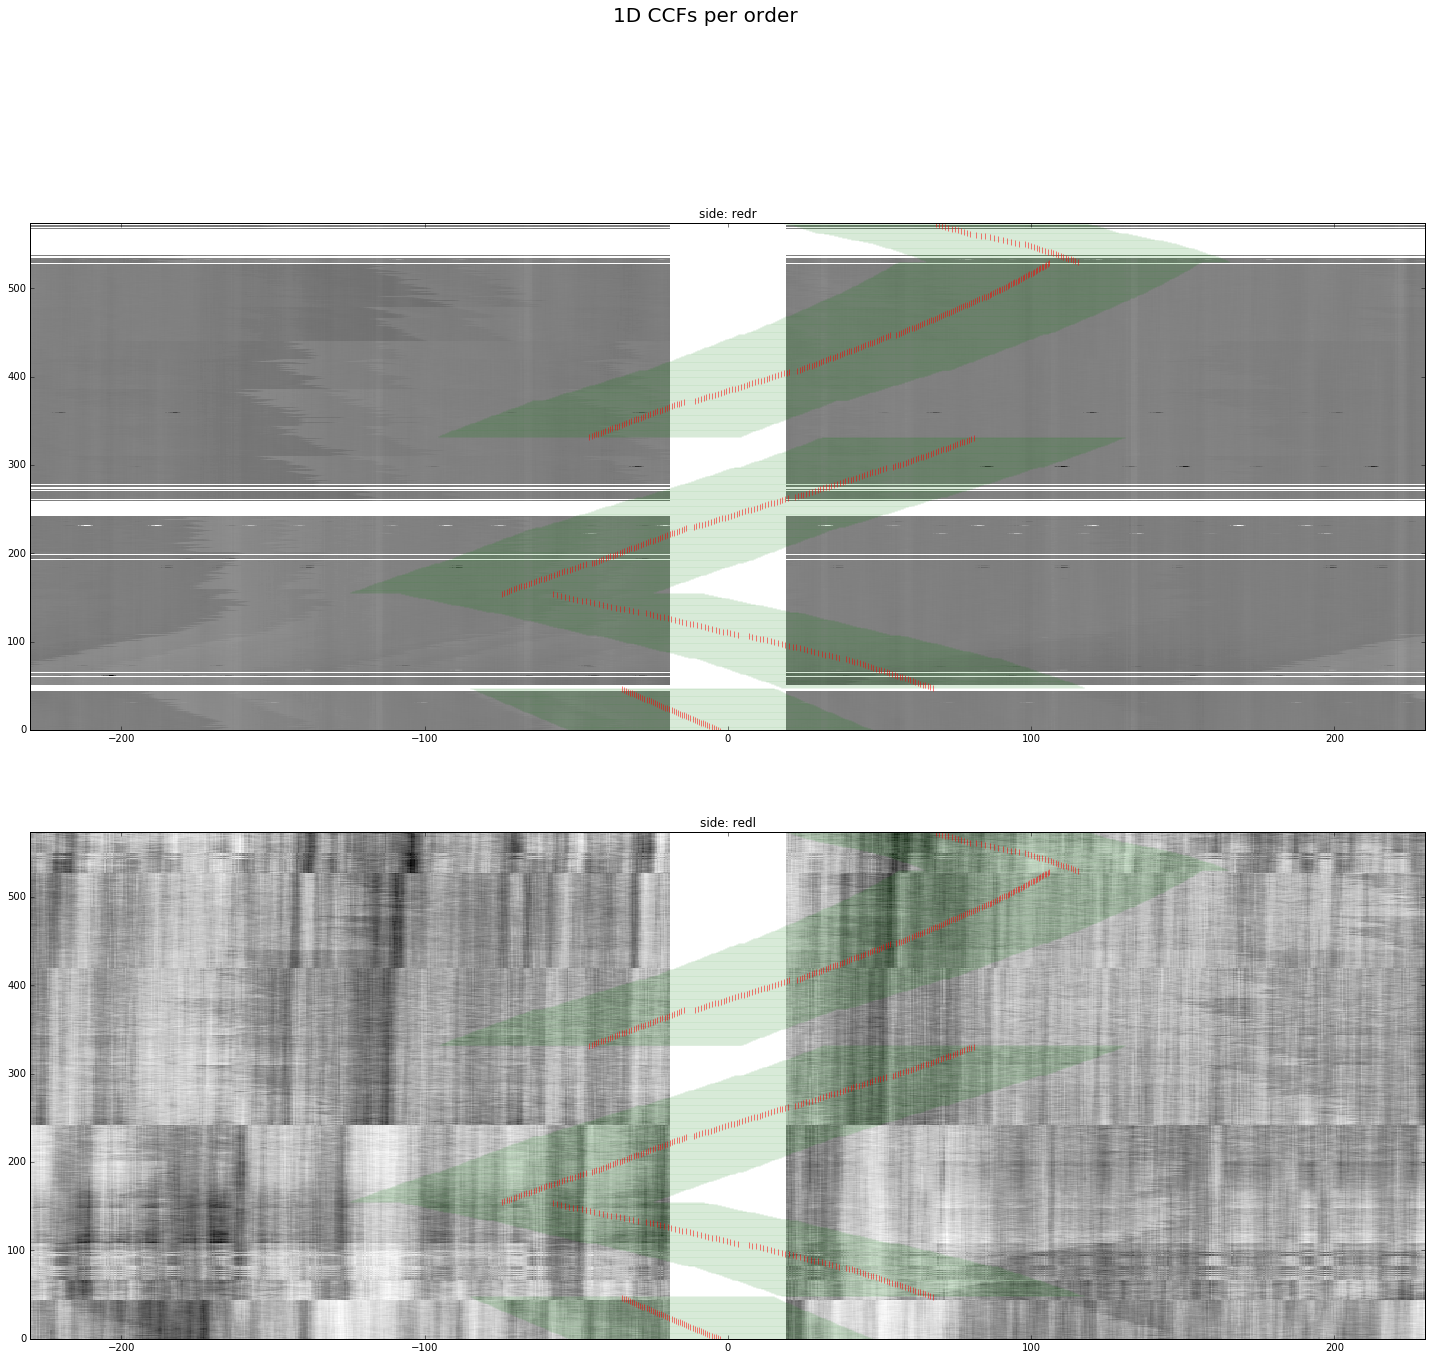

In [125]:
#2D ccfs
figNormCCfsOrders2D, axesNormCCfsOrders2D =mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

for side, axIndex in zip(sideList, np.arange(len(sideList))):
    
    axesNormCCfsOrders2D[axIndex].imshow([normCCFs[fileName]/np.nanmedian(normCCFs[fileName]) for fileName in sorted(sideFileList[side])], aspect='auto', cmap=cm.Greys,interpolation='nearest',\
           extent= [min(waveFile), max(waveFile), 0, len(sorted(sideFileList[side]))])

    axesNormCCfsOrders2D[axIndex].set_ylim([0, len(sorted(sideFileList[side]))])
    axesNormCCfsOrders2D[axIndex].set_xlim([min(waveFile), max(waveFile)])
    axesNormCCfsOrders2D[axIndex].set_title('side: {}'.format(side))
    
    axesNormCCfsOrders2D[axIndex].plot([RVs[fileName] for fileName in sorted(sideFileList[side])], [yy-.5 for yy in np.arange(len(sideFileList[side]))], 'r|')
    
    for fileName,yy  in zip(sorted(sideFileList[side]),np.arange(len(sideFileList[side]))):
        axesNormCCfsOrders2D[axIndex].add_patch(patches.Rectangle( (RVs[fileName]- planetTrimRV, yy), 2*planetTrimRV, 1., color='g', alpha=0.05))
    

figNormCCfsOrders2D.suptitle('1D CCFs per order'.format(side), y=1.05, fontsize = 20) 






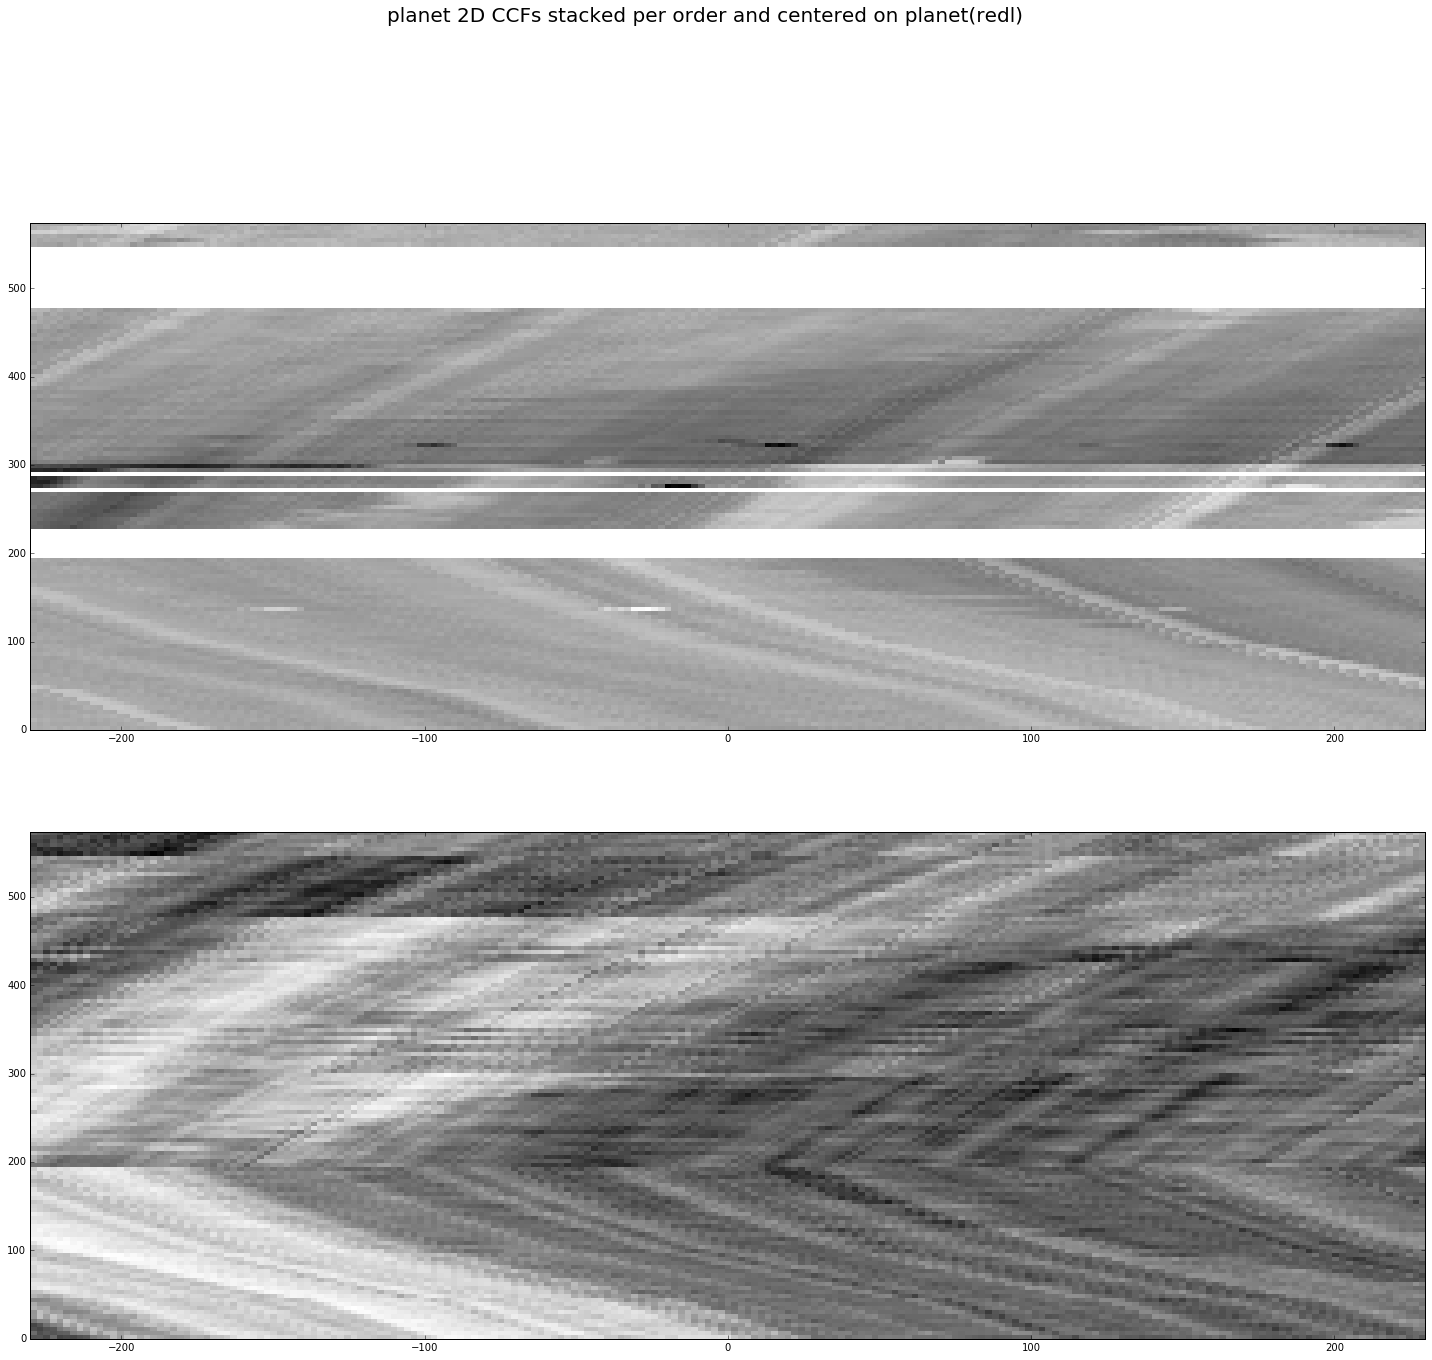

In [126]:
# 2D CCFs selected centered on planet and selected byt RV
step = abs(waveFile[1]-waveFile[0])

figNormCCfsOrders2D, axesNormCCfsOrders2D =mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

ccfPlanetCentered = {}

for side, axIndex in zip(sideList, np.arange(len(sideList))):
    ccfPlanetCentered[side] = [(normCCFs[fileName]/np.nanmedian(normCCFs[fileName]))[RVIndexes[fileName]-planetTrimRV/step:RVIndexes[fileName] + planetTrimRV/step] \
                    for fileName in sorted(sideFileList[side]) \
                    if (abs(RVs[fileName]) > (planetTrimRV + ccfStarTrimRV)) ]
    
    
    axesNormCCfsOrders2D[axIndex].imshow(ccfPlanetCentered[side], \
                              aspect='auto', cmap=cm.Greys,interpolation='nearest',\
                              extent= [min(waveFile), max(waveFile), 0, len(sideFileList[side])]\
                              )


figNormCCfsOrders2D.suptitle('planet 2D CCFs stacked per order and centered on planet({})'.format(side), y=1.05, fontsize = 20) 


mplt.show()

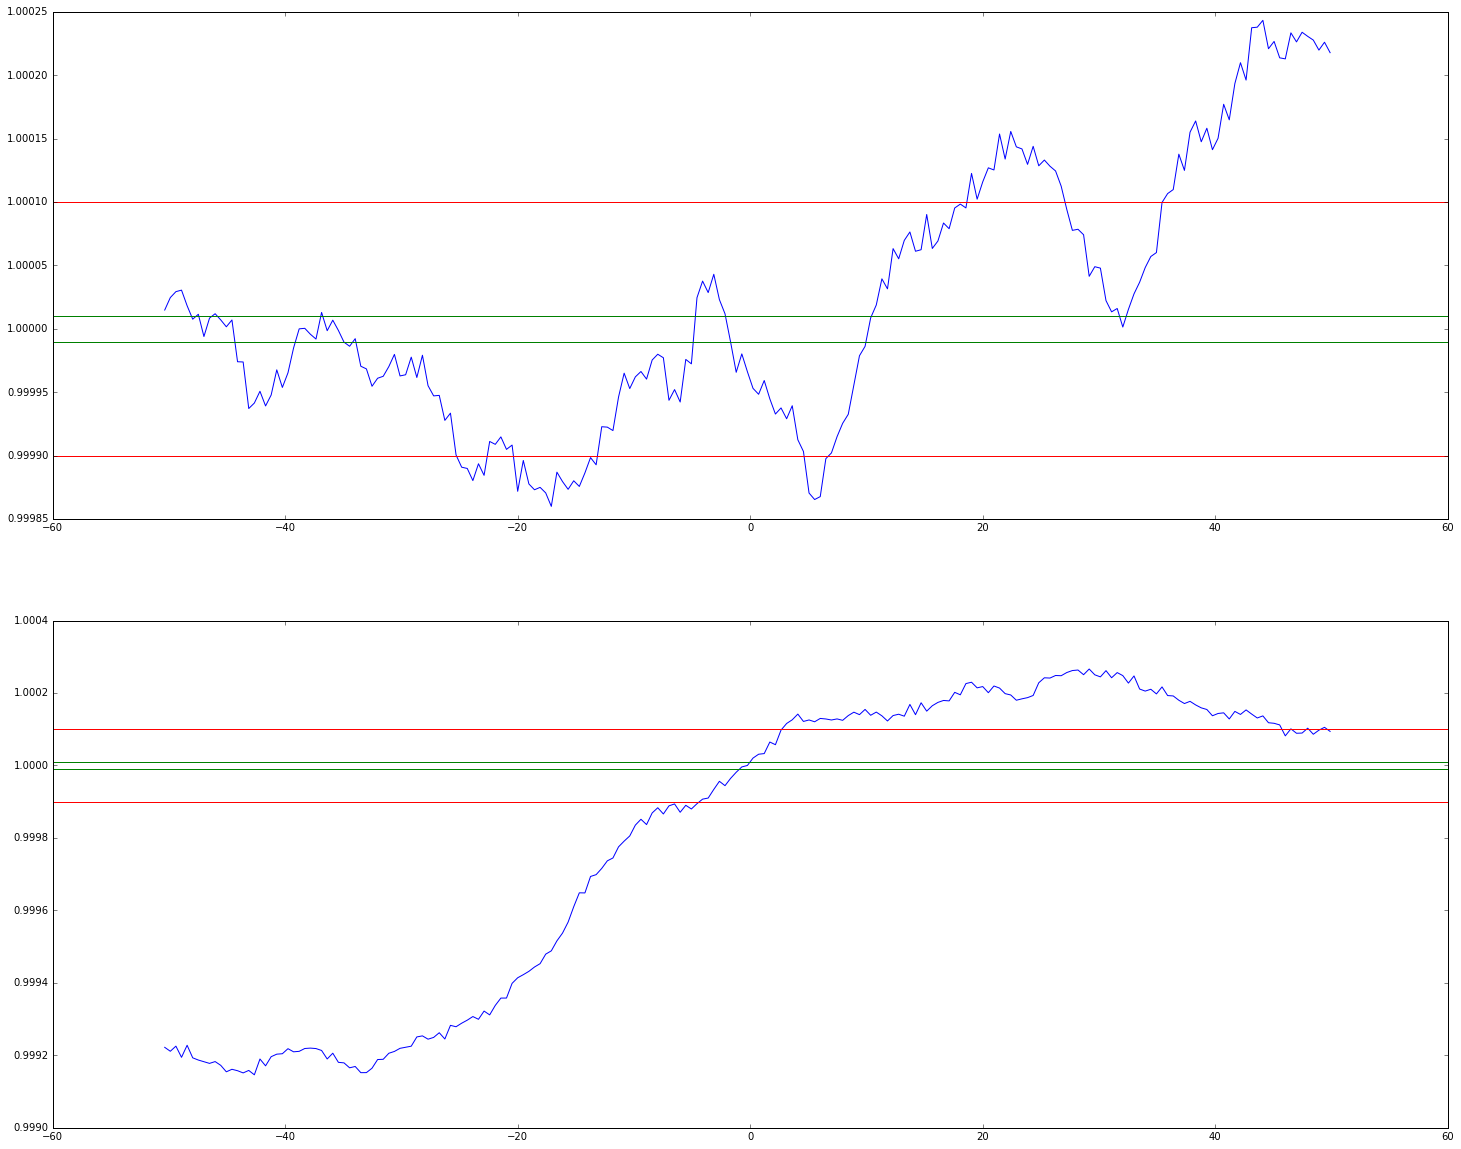

In [127]:
# CCF sum "Planet"

figPlanetCCF, axesPlanetCCF =mplt.subplots(len(sideList), 1, figsize=(25,20), dpi = 100)

ccfSum = {}

for side, axIndex in zip(sideList, np.arange(len(sideList))):
    ccfSum[side] = np.nansum(ccfPlanetCentered[side], axis=0)
    axesPlanetCCF[axIndex].plot(np.linspace(-len(ccfSum[side])/2*step,len(ccfSum[side])/2*step, num = len(ccfSum[side]) ),ccfSum[side]/np.nanmedian(ccfSum[side]))
    axesPlanetCCF[axIndex].ticklabel_format(useOffset=False)
    axesPlanetCCF[axIndex].axhline(1.-1e-4, color='red')
    axesPlanetCCF[axIndex].axhline(1.+1e-4, color='red')
    axesPlanetCCF[axIndex].axhline(1.-1e-5, color='green')
    axesPlanetCCF[axIndex].axhline(1.+1e-5, color='green')

mplt.show()